# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

Populating the interactive namespace from numpy and matplotlib


In [2]:
p = 3   # spline degree 
n_el = (30,15)   #(30,15)# number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [3]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

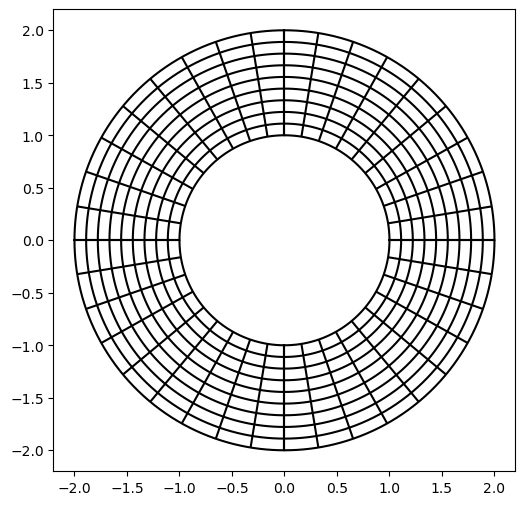

In [4]:
figsize(8,6)
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [5]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [6]:
# source term f 
def f(x, y): return (0.0, 0.0)
def f_zero(x, y): return (0.0)

#Neumann BC
def gN(x, y): return (1.5e-4, -1.5e-4) 

neu_data = [
    (3,'right',gN) 
]

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )



In [7]:
def u1(x,y): return 3*x**2 # 2*y)

A, b,_ = MP_u.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f= u1)

u_1= solvers.make_solver(A).dot(b)

In [8]:

u_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u_1)
           for p in range(len(patches_u))]

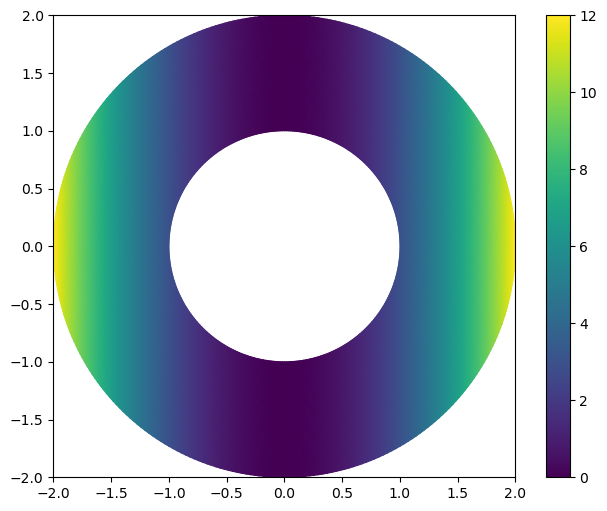

In [9]:
u_1
figsize(8,6)

for (u_func, (kvs, geo)) in zip(u_funcs, patches_u):
    vis.plot_field(u_func, geo, vmin=0, vmax=12)
axis('scaled')
colorbar();

In [10]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)
# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero )
])

In [11]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    
    # grid variables
    ref = 10
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    
    figsize(10,10)
    fig, ax = plt.subplots()
    
     # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-4)
        
    colorbar();
    axis('equal')


In [12]:
# Compute solution of nonlinear elasticity problem

In [13]:
#split the solution into its components (displacement in x- and y- direction)
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [14]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A
    
    return A_lin_lam + A_lin_mu


def J_u(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    f4 = assemble.assemble('sin(x[0]) * cos(x[1]) * v * dx', kvs_ux, geo=geo_ux)
    print('Integral:', f4.sum())
    
     
    f5 = assemble.assemble('v * ds', kvs_ux, geo=geo_ux, boundary='left')
    # r=1 at inner mantle, one quarter of the full circle
    print('f5=', np.allclose(f5.sum(), (2 * 1 * np.pi) / 4))
    
    
    j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))* tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis)) *dx'
                             , kvs_ux, bfuns=[('v',1)], geo=geo_ux, dis=dis)
    j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis)))  *dx'
                                    , kvs_ux, bfuns=[('v',1)], geo=geo_ux, dis=dis)
    j_u = (j_lam + j_mu).ravel() 
    
    return j_u #.sum()  # sum of vector (=inner product with const v=1)



In [15]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]
        
        #dis = get_components(X.T @ u, kvs_ux)

        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form

        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs

        # The patch-local Neumann boundary data
        for item in neu_data:
            if item[0]==p:
                N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_e[c,i,0]

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p 
    
    return A, b

In [16]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) # u
    # a(u,v)-l(v)
    u_p = x
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        b_p= apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)

        b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs (0,0,...,0) for nbc
        
        #dis = get_components(X.T @ u_p, kvs_ux)
        
        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                #print('N=',N_e)
                #print(shape(N_e))
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b0_p[bdofs[i]+offset] += N_e[c,i,0]
        #print(b0_p)            
        if first:
            grad_b = X @ (b_p- b0_p)#"Au-b"
            first = False
        else:
            grad_b += X @ (b_p- b0_p) 
            
    return grad_b



kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=1) for n in n_el) # constant basis vector for integration

def J(x): #energy functional
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        #print('j_p0=', j_lam + j_mu)
        j_p = sum(j_lam + j_mu)
        #print('j_p=', j_p)
        

        
        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) #*v?
                #print('N=',N_e)
                j_N += N_e.sum()
        #print('j_N=', j_N)

        j += (j_p - j_N)

    #print('J_u=', j)
    return j


In [17]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.5
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    ##NEW
    tau1 = 0.3
    tau2 = 0.9    
    ##
    
    
    def phi(alpha):
        #print('pk=', pk)
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 # alpha=1 geht nicht?, 0.9 for small deformation 
    phi_min = -1.e2
    ##NEW
    phi_min = 1e-6
    ##
    eps0 = 1.e-6
    max_iter = 10
    n_iter = 0
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1: # alpha too big # alpha in(0,1)!
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                print('  phi_hat=', phi_hat)
                #print('cond1: ', phi(0) + mu1*alpha*derphi(0))
                print('  phi_0=', phi(0))
                print('  derphi_0=', derphi(0))
                if derphi(0) >= 0:
                    print('  no descent direction')
                
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
                print('  delta=', delta)
                # interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                #print('alpha_int=', alpha)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    print('  alpha too small')
                    if alphainf: # true, alpha_R =inf
                        print('  alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        print('  alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    # update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha
                    #break


                
                        

In [18]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False)
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [19]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    except LinAlgError:
        print('use Gradient dir') # matrix not positive definite
        return 10000*vector
        
        

In [24]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
#print(dd)

#initial value
u= np.zeros(dd)
#print(u)


### first iteration ###
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
#print(ass_nonlinsystem(u)[1])

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solve(LS.A, LS.b)

u_d = LS.complete(u_d)
print(u_d)

x1= J(u)
print(x1)
x2= grad_J(u)
print(x2)
#alpha = Wolfe2(J, grad_J, u, u_d)
print('Start line search')
alpha= Wolfe_LineSearch(J, grad_J, u, u_d)
print('alpha=', alpha)

u += alpha*u_d
#u += u_d
#print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

r0= r


# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

residual =  0.00011968213642976939
[ 0.04553169  0.0455516   0.04563331 ... -0.14645575 -0.13903598
 -0.13453593]
0.0
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 3.54927565e-06]
Start line search
  0. alpha between 0 and None
alpha= 1


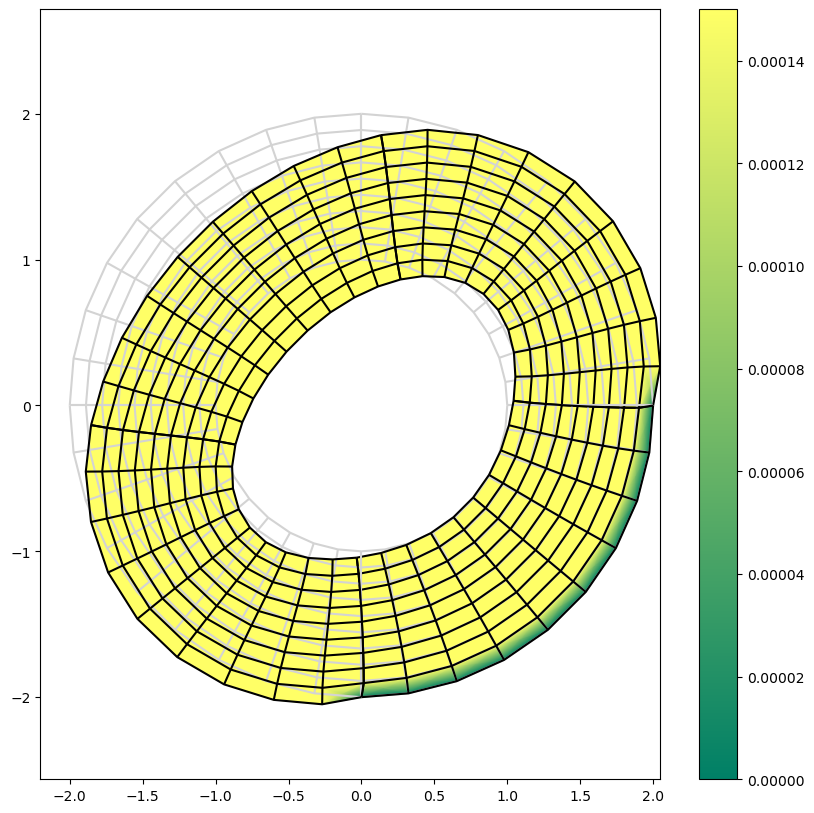

In [25]:
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)


In [26]:
# solve linearized variational problem
epsilon= 1e-6
count= 1

stepsizes =[] 
ud_array = []

while True:
    count+=1
    print(count)
    # Assemble matrices and rhs in every iteration step
    A, b= ass_nonlinsystem(u)
    LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
    
    r= np.linalg.norm(LS.b) # compute residuum
    print('residual = ', r)

    
    u_d= solve(LS.A, LS.b)


    u_d = LS.complete(u_d)
    
    #alpha = Wolfe2(J, grad_J, u, u_d)
    gd  = -grad_J(u_d)
    print('Start line search')
    alpha= Wolfe_LineSearch(J, grad_J, u, u_d)
    print('alpha=', alpha)

    u += alpha*u_d
    #print(u)
   
    ud_array.append(u_d)
    
    normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = abs(normed_du0-normed_du)
    #print('norm(delta_u) = ', normed_du)
    #print ('step size u_d = ', stepsize_du)
    
    stepsizes.append(stepsize_du)
    
    if r < epsilon*r0:
        break
    elif count == 30:
        break
        
    normed_du0 = normed_du

# print deformation plot
get_defplot(u, patches_u, kvs_u)
#print(u)

2
residual =  8.184487497731701e-05
use Gradient dir
Start line search
  0. alpha between 0 and None
  phi_hat= 0.00013400391927939693
  phi_0= -0.00015511603932003452
  derphi_0= -6.698583560052651e-05
  delta= 1
  1. alpha between 0 and 1
alpha= 0.1
3
residual =  0.0008318727604961509
use Gradient dir
Start line search
  0. alpha between 0 and None
  phi_hat= 0.3295496269390212
  phi_0= -0.0001495631327784524
  derphi_0= -0.006920122896554864
  delta= 1
  1. alpha between 0 and 1
  phi_hat= 0.00029671251360146233
  phi_0= -0.0001495631327784524
  derphi_0= -0.006920122896554864
  delta= 0.1
  2. alpha between 0 and 0.1
alpha= 0.03039706684697591
4
residual =  0.004324577605505051
use Gradient dir
Start line search
  0. alpha between 0 and None
  phi_hat= 1780.720462339886
  phi_0= -0.00012103502636948515
  derphi_0= -0.187019714660358
  delta= 1
  1. alpha between 0 and 1
  phi_hat= 0.10102892542836639
  phi_0= -0.00012103502636948515
  derphi_0= -0.187019714660358
  delta= 0.1
  2. 

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [ ]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    mu1 = 0.01
    sigma = 0.9
    tau1= 0.3
    tau2 = 0.9
    gsi1= 1
    gsi2=10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha= 1
    phi_min = 1.e-6
    
    while True:
        print("alpha between {} and {}".format(alpha_L,alpha_R))
        if alpha > 1: # alpha to big
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            phi_hat= phi(alpha)
            if phi_hat < phi_min:
                return alpha 
            if phi_hat > phi(0) + mu1*alpha*derphi(0):
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too smal
                    if alphainf: # true
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else:
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha
                    #break
    
                
    

In [ ]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]
#print(dd)

#initial value
u= np.zeros(dd)
#print(u)


### first iteration ###
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solvers.make_solver(LS.A).dot(LS.b)

u_d = LS.complete(u_d)


x1= J(u)
print(x1)
#x2= grad_J(u)
#print(x2)
alpha= WolfeLineSearch(J, grad_J, u, u_d)
print('alpha=', alpha)

u += alpha[0]*u_d
print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

In [ ]:
A, b= ass_nonlinsystem(u)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

u_d= solvers.make_solver(LS.A).dot(LS.b)

u_d = LS.complete(u_d)


x1= J(u)
print(x1)
#x2= grad_J(u)
#print(x2)
alpha= WolfeLineSearch(J, grad_J, u, u_d)
print('alpha=', alpha)

u += alpha[0]*u_d
print(u)


solution = [LS.restrict(u)]
#print(solution[-1])

# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))

In [ ]:
def obj_func(x):
    return (x[0])**2+(x[1])**2
def obj_grad(x):
    return [2*x[0], 2*x[1]]

In [ ]:
start_point = np.array([1.8, 1.7])
search_gradient = np.array([-1.0, -1.0])
line_search(obj_func, obj_grad, start_point, search_gradient)

In [ ]:
alpha= Wolfe_LineSearch(obj_func, obj_grad, start_point, search_gradient)
print('alpha=', alpha)
